In [46]:
import numpy as np
%load_ext autoreload
%autoreload 0
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
from qiskit.circuit import QuantumCircuit
from qiskit.circuit import Parameter

from estimator import Estimator
from estimator import BasicEstimator

In [48]:
from qiskit import Aer, execute
qasm_simulator = Aer.get_backend('qasm_simulator')

In [49]:
from pauli_string import PauliString
from hamiltonian import MolecularFermionicHamiltonian
from mapping import JordanWigner
from scipy.optimize import minimize
from solver import VQESolver

## VQE on a quantum simulator

In [245]:
def read_integrals(distance):
    with open('H2_hamiltonian_integrals/Integrals_H2_no_spin_d_'+str(distance)+'.npz','rb') as f:

        out = np.load(f)
        h1_load_no_spin = out['h1']
        h2_load_no_spin = out['h2']
        energy_nuc =  out['energy_nuc']
        distance = out['distance']

    molecular_hamiltonian = MolecularFermionicHamiltonian.from_integrals(h1_load_no_spin,h2_load_no_spin).include_spin()

    mapping = JordanWigner()
    qubit_hamiltonian = mapping.fermionic_hamiltonian_to_qubit_hamiltonian(molecular_hamiltonian).sort()
    qubit_hamiltonian = qubit_hamiltonian.apply_threshold().combine().apply_threshold().sort()
    return (qubit_hamiltonian, energy_nuc)



def initial_state_circuit():
    varform_4qubits_1param = QuantumCircuit(4)
    a = Parameter('a')
    varform_4qubits_1param.x(0)
    varform_4qubits_1param.rx(a,1)
    varform_4qubits_1param.cx(1,0)
    varform_4qubits_1param.cx(0,2)
    varform_4qubits_1param.cx(1,3)
    
    return varform_4qubits_1param

def Estimator(read_integrals, initial_state_circuit, backend, execute_opts):
    qubit_hamiltonian = read_integrals(distance)[0]
    varform = initial_state_circuit()
#     backend = qasm_simulator
#     execute_opts = {'shots' : 2048}
    estimator = BasicEstimator(varform, backend,execute_opts = execute_opts)
    estimator.set_observable(qubit_hamiltonian)
    params = [10,]
    expected_value = estimator.eval(params)
    
    return estimator

minimizer = lambda fct, start_param_values : minimize(
    fct,
    start_param_values,
    method = 'SLSQP', 
    options = {'maxiter' : 5,'eps' : 1e-1, 'ftol' : 1e-4, 'disp' : True, 'iprint' : 0})

## Qasm simulator

In [247]:
backend = qasm_simulator
execute_opts = {'shots' : 2048}

params = [10,]

d1 = np.arange(0.2,2.5,0.2)
d2 =np.array([0.735])
distance_array = np.concatenate((d1, d2))
distance_array = np.sort(distance_array)
                         
opt_param_list = []
Ground_state_energy = []

for i, distance in enumerate(distance_array):
    distance = np.round(distance,decimals = 3)
    qubit_hamiltonian = read_integrals(distance)[0]
    energy_nuc = read_integrals(distance)[1]
    

    estimator = Estimator(read_integrals, initial_state_circuit, backend, execute_opts)
    vqe_solver = VQESolver(estimator,minimizer,params,name = 'vqe_solver')
    opt_value = vqe_solver.lowest_eig_value(qubit_hamiltonian)
#     print('Ground state position estimate (vqe) : ', vqe_solver.last_opt_params)
#     print('Ground state energy estimate (electronic, vqe) : ', opt_value)
    opt_param_list.append(vqe_solver.last_opt_params)
    Ground_state_energy.append(opt_value + energy_nuc)
    print('distance :'+str(distance)+', energy : ', opt_value + energy_nuc)

distance :0.2, energy :  0.17088109882359692
distance :0.4, energy :  -0.9077352456327517
distance :0.6, energy :  -1.1023582687981266
distance :0.735, energy :  -1.105249664398705
distance :0.8, energy :  -1.1084489120903058
distance :1.0, energy :  -1.0667073139352223
distance :1.2, energy :  -1.008026167923831
distance :1.4, energy :  -0.9377635976968335
distance :1.6, energy :  -0.4812359514820007
distance :1.8, energy :  -0.8301067145685422
distance :2.0, energy :  -0.7642413770175245
distance :2.2, energy :  -0.5815409621913304
distance :2.4, energy :  -0.6029111914305515


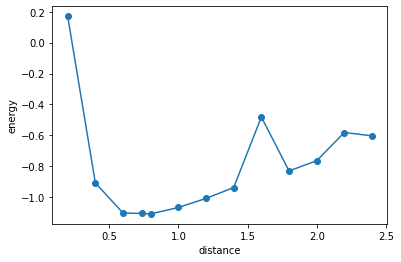

In [248]:
plt.plot(distance_array, Ground_state_energy, 'o-')
plt.xlabel('distance')
plt.ylabel('energy')
plt.show()

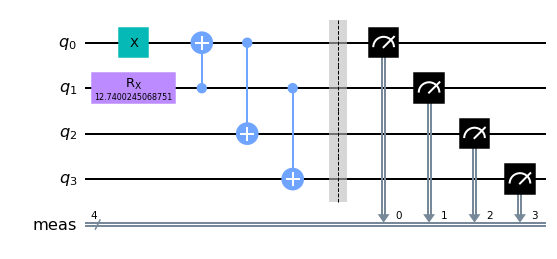

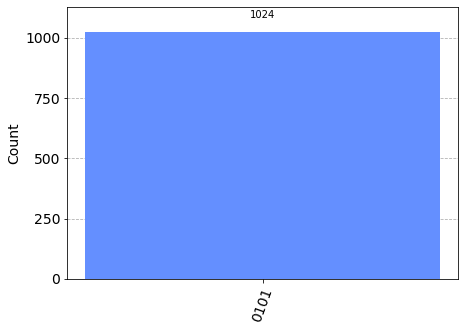

In [249]:
eigenstate_qc_list_qasm = []
counts_list_qasm = []
for i, distance in enumerate(distance_array):
    varform = initial_state_circuit()
    eigenstate_qc = varform.copy()
    eigenstate_qc.measure_all()
    opt_params = opt_param_list[i]

    param_dict = dict(zip(eigenstate_qc.parameters,opt_params))
    eigenstate_qc = eigenstate_qc.assign_parameters(param_dict)
    
    execute_opts = {'shots' : 1024}
    job = execute(eigenstate_qc,backend=qasm_simulator,**execute_opts)
    result = job.result()
    counts = result.get_counts(eigenstate_qc)
    
    eigenstate_qc_list_qasm.append(eigenstate_qc)
    counts_list_qasm.append(counts)
    
    
    
    
i = 3
display(eigenstate_qc_list_qasm[i].draw('mpl'))
counts_list_qasm[i]



from qiskit.visualization import plot_histogram
plot_histogram(counts_list[i])

## Exact solution

In [228]:
from solver import ExactSolver

In [229]:
exact_solver = ExactSolver()
d1 = np.arange(0.2,2.5,0.2)
d2 =np.array([0.735])
distance_array = np.concatenate((d1, d2))
distance_array = np.sort(distance_array)

ground_state_vector_exact = []
ground_state_energy_exact = []
for i, distance in enumerate(distance_array):
    distance = np.round(distance,decimals = 3)
    qubit_hamiltonian = read_integrals(distance)[0]
    energy_nuc = read_integrals(distance)[1]
    ground_state_value = exact_solver.lowest_eig_value(qubit_hamiltonian)
    ground_state_vector = exact_solver.last_opt_params
    
    ground_state_vector_exact.append(ground_state_vector)
    ground_state_energy_exact.append(ground_state_value + energy_nuc)
    
#     print('Ground state vector (exact) : ', ground_state_vector)
#     print('Ground state energy (electronic, exact) : ', ground_state_value)
    print('distance: '+str(distance)+', energy : ', ground_state_value + energy_nuc)


distance: 0.2, energy :  0.15748213479836393
distance: 0.4, energy :  -0.9141497046270834
distance: 0.6, energy :  -1.1162860068695397
distance: 0.735, energy :  -1.1373060357534004
distance: 0.8, energy :  -1.1341476666770955
distance: 1.0, energy :  -1.1011503302326182
distance: 1.2, energy :  -1.0567407463052576
distance: 1.4, energy :  -1.0154682492882452
distance: 1.6, energy :  -0.9834727290331733
distance: 1.8, energy :  -0.961816952792581
distance: 2.0, energy :  -0.9486411121761855
distance: 2.2, energy :  -0.9412240336932618
distance: 2.4, energy :  -0.9372549530096289


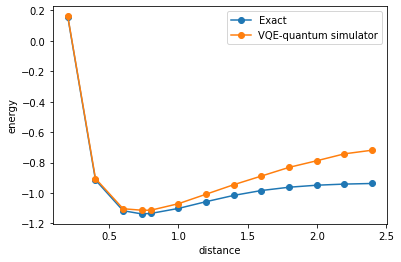

In [230]:
plt.plot(distance_array, ground_state_energy_exact, 'o-', label = 'Exact')
plt.plot(distance_array, Ground_state_energy, 'o-', label = 'VQE-quantum simulator')

plt.xlabel('distance')
plt.ylabel('energy')
plt.legend()
plt.show()

[0.00000000e+00 0.00000000e+00 9.86076132e-32 3.44265545e-16
 6.88531091e-17 9.93760401e-01 4.05592908e-16 7.77015473e-17
 2.22044605e-16 1.90819582e-17 1.11535939e-01 5.20417037e-18
 4.89524924e-17 2.77555756e-17 1.79958894e-30 2.28941320e-64]


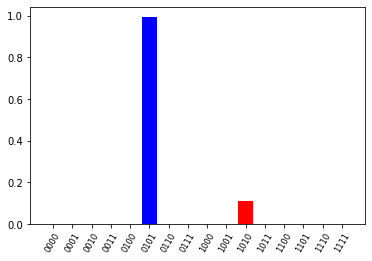

In [252]:
i = 3
gs = ground_state_vector_exact[i]
fig,ax = plt.subplots(1,1)
i_max = np.argmax(np.abs(gs))
state = gs * np.sign(gs[i_max])

print(np.abs(state))
ax.bar(range(len(state)),np.abs(state),color=(np.real(state) > 0).choose(['r','b']))
plt.xticks(range(len(state)),[f"{i:04b}" for i in range(len(state))], size='small',rotation=60);

In [163]:
i_max = np.argmax(np.abs(gs))
state = gs * np.sign(gs[i_max])
print(np.sign(gs[i_max]))

(-1+0j)


In [107]:
from qiskit import IBMQ

# IBMQ.save_account('762d9159144a705fba6eb963a1e84844c2ada26d066444d24db420e7cc3d49a53ed78a05197fb0dfa2e76fd82a009dfb46f183e1b52f9313b392e10f4a210fe5')
IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [108]:
IBMQ.providers()


[<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>,
 <AccountProvider for IBMQ(hub='ibm-q-qida', group='pinq2', project='winter-school')>]

In [110]:
provider = IBMQ.get_provider(hub='ibm-q-qida', group='pinq2', project='winter-school')
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q-qida', group='pinq2', project='winter-school')>,
 <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q-qida', group='pinq2', project='winter-school')>,
 <IBMQBackend('ibmq_jakarta') from IBMQ(hub='ibm-q-qida', group='pinq2', project='winter-school')>,
 <IBMQBackend('ibm_lagos') from IBMQ(hub='ibm-q-qida', group='pinq2', project='winter-school')>,
 <IBMQBackend('ibm_nairobi') from IBMQ(hub='ibm-q-qida', group='pinq2', project='winter-school')>,
 <IBMQBackend('ibm_perth') from IBMQ(hub='ibm-q-qida', group='pinq2', project='winter-school')>,
 <IBMQBackend('ibm_oslo') from IBMQ(hub='ibm-q-qida', group='pinq2', project='winter-school')>]

## ibm_qasm_simulator

In [111]:
# ibm_simulator = provider.get_backend('ibmq_qasm_simulator')
# 

In [112]:
# def Estimator(read_integrals, initial_state_circuit):
#     qubit_hamiltonian = read_integrals(distance)[0]
#     varform = initial_state_circuit()
#     backend = ibm_simulator
#     execute_opts = {'shots' : 2048}
#     estimator = BasicEstimator(varform, backend,execute_opts = execute_opts)
#     estimator.set_observable(qubit_hamiltonian)
#     params = [0,]
#     expected_value = estimator.eval(params)
    
#     return estimator

In [114]:
# distance_array = np.arange(0.2,2.5,0.2)
# # distance_array = np.arange(0.735, 0.935, 0.2)
# opt_param_ibm_simulator1 = []
# GS_ibm_simulator1 = []

# for i, distance in enumerate(distance_array):
#     distance = np.round(distance,decimals = 3)
#     qubit_hamiltonian = read_integrals(distance)[0]
#     energy_nuc = read_integrals(distance)[1]
    

#      estimator = Estimator(read_integrals, initial_state_circuit, backend, execute_opts)
#     vqe_solver = VQESolver(estimator,minimizer,[0,],name = 'vqe_solver')
#     opt_value = vqe_solver.lowest_eig_value(qubit_hamiltonian)
# #     print('Ground state position estimate (vqe) : ', vqe_solver.last_opt_params)
# #     print('Ground state energy estimate (electronic, vqe) : ', opt_value)
#     opt_param_ibm_simulator1.append(vqe_solver.last_opt_params)
#     GS_ibm_simulator1.append(opt_value + energy_nuc)
#     print('distance '+str(distance)+', energy : ', opt_value + energy_nuc)

Ground state energy estimate at distance 0.2 (molecular, vqe) :  0.16509408093734068
Ground state energy estimate at distance 0.4 (molecular, vqe) :  -0.9037979979190629
Ground state energy estimate at distance 0.6 (molecular, vqe) :  -1.1020938641390856
Ground state energy estimate at distance 0.8 (molecular, vqe) :  -1.11211249462981
Ground state energy estimate at distance 1.0 (molecular, vqe) :  -1.0673974341142665
Ground state energy estimate at distance 1.2 (molecular, vqe) :  -1.007695241006822
Ground state energy estimate at distance 1.4 (molecular, vqe) :  -0.940663923424566
Ground state energy estimate at distance 1.6 (molecular, vqe) :  -0.8828843116911662
Ground state energy estimate at distance 1.8 (molecular, vqe) :  -0.834634945280217
Ground state energy estimate at distance 2.0 (molecular, vqe) :  -0.7841081721793843
Ground state energy estimate at distance 2.2 (molecular, vqe) :  -0.7502786101230853
Ground state energy estimate at distance 2.4 (molecular, vqe) :  -0.71

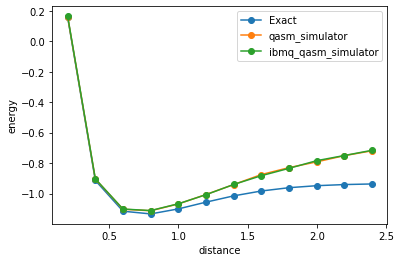

In [123]:
plt.plot(distance_array, ground_state_energy_exact, 'o-', label = 'Exact')
plt.plot(distance_array, Ground_state_energy, 'o-', label = 'qasm_simulator')
plt.plot(distance_array, GS_ibm_simulator, 'o-', label = 'ibmq_qasm_simulator')

plt.xlabel('distance')
plt.ylabel('energy')
plt.legend()
plt.show()

## On a actual quantum hardware

In [ ]:
backend = provider.get_backend('ibmq_jakarta')
execute_opts = {'shots' : 2048}
params = [0,]
# d1 = np.arange(0.2,2.5,0.2)
# d2 =np.array([0.735])
# distance_array = np.concatenate((d1, d2))
# distance_array = np.sort(distance_array)

distance_array = ([0.735])
# distance_array = np.arange(0.735, 0.935, 0.2)
opt_param_ibm_simulator = []
GS_ibm_simulator = []

for i, distance in enumerate(distance_array):
    distance = np.round(distance,decimals = 3)
    qubit_hamiltonian = read_integrals(distance)[0]
    energy_nuc = read_integrals(distance)[1]
    

    estimator = Estimator(read_integrals, initial_state_circuit, backend, execute_opts)
    vqe_solver = VQESolver(estimator,minimizer,params,name = 'vqe_solver')
    opt_value = vqe_solver.lowest_eig_value(qubit_hamiltonian)
#     print('Ground state position estimate (vqe) : ', vqe_solver.last_opt_params)
#     print('Ground state energy estimate (electronic, vqe) : ', opt_value)
    opt_param_ibm_simulator.append(vqe_solver.last_opt_params)
    GS_ibm_simulator.append(opt_value + energy_nuc)
    print('distance: '+str(distance)+', energy : ', opt_value + energy_nuc)
    
    
#  parameter =0 , Ground state energy estimate at distance 0.735 (molecular, vqe) :  -0.963777238071391   
# parameter = 10, distance: 0.735, energy :  -1.0195862849176636

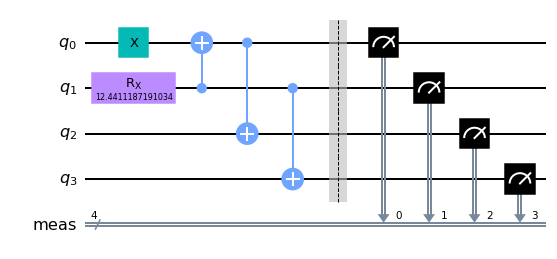

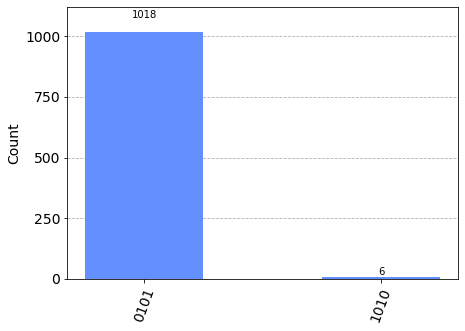

In [253]:
eigenstate_qc_list_jak = []
counts_list_jak = []
for i, distance in enumerate(distance_array):
    varform = initial_state_circuit()
    eigenstate_qc = varform.copy()
    eigenstate_qc.measure_all()
    opt_params = opt_param_ibm_simulator[i]

    param_dict = dict(zip(eigenstate_qc.parameters,opt_params))
    eigenstate_qc = eigenstate_qc.assign_parameters(param_dict)
    
    execute_opts = {'shots' : 1024}
    job = execute(eigenstate_qc,backend=qasm_simulator,**execute_opts)
    result = job.result()
    counts = result.get_counts(eigenstate_qc)
    
    eigenstate_qc_list_jak.append(eigenstate_qc)
    counts_list_jak.append(counts)
    
    
    
    
i = 0
display(eigenstate_qc_list_jak[i].draw('mpl'))
counts_list_jak[i]



from qiskit.visualization import plot_histogram
plot_histogram(counts_list_jak[i])

## Noisy simulation

In [232]:
from qiskit.providers.fake_provider import FakeBelem
from qiskit_aer.noise import NoiseModel

from qiskit import Aer, execute
qasm_simulator = Aer.get_backend('qasm_simulator')

In [233]:
fake_noisy_backend = FakeBelem()
noise_model = NoiseModel.from_backend(fake_noisy_backend)


In [234]:
backend = qasm_simulator
execute_opts = {'shots' :2048, "noise_model": noise_model, 
                "basis_gates": fake_noisy_backend.configuration().basis_gates, 
                "coupling_map": fake_noisy_backend.configuration().coupling_map, 
                "seed_simulator": 42, "optimization_level" : 0, "resiliance_level" : 0}


d1 = np.arange(0.2,2.5,0.2)
d2 =np.array([0.735])
distance_array = np.concatenate((d1, d2))
distance_array = np.sort(distance_array)
# distance_array = np.arange(0.735, 0.935, 0.2)
opt_param_qasm_noisy = []
GS_qasm_noisy = []

for i, distance in enumerate(distance_array):
    distance = np.round(distance,decimals = 3)
    qubit_hamiltonian = read_integrals(distance)[0]
    energy_nuc = read_integrals(distance)[1]
    

    estimator = Estimator(read_integrals, initial_state_circuit, backend, execute_opts)
    vqe_solver = VQESolver(estimator,minimizer,[0,],name = 'vqe_solver')
    opt_value = vqe_solver.lowest_eig_value(qubit_hamiltonian)

    opt_param_qasm_noisy.append(vqe_solver.last_opt_params)
    GS_qasm_noisy.append(opt_value + energy_nuc)
    print('distance '+str(distance)+', energy : ', opt_value + energy_nuc)

distance 0.2, energy :  0.464630153061647
distance 0.4, energy :  -0.6770810426548404
distance 0.6, energy :  -0.8905174386770328
distance 0.735, energy :  -0.95809065787499
distance 0.8, energy :  -0.9381881975067059
distance 1.0, energy :  -0.9359339795929623
distance 1.2, energy :  -0.8931966146499323
distance 1.4, energy :  -0.8449559209139548
distance 1.6, energy :  -0.7818851308278882
distance 1.8, energy :  -0.7512327725224314
distance 2.0, energy :  -0.7048134546445666
distance 2.2, energy :  -0.6837678943550886
distance 2.4, energy :  -0.6703594640317708


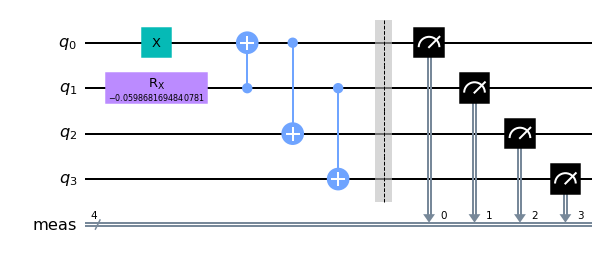

{'0101': 1020, '1010': 4}


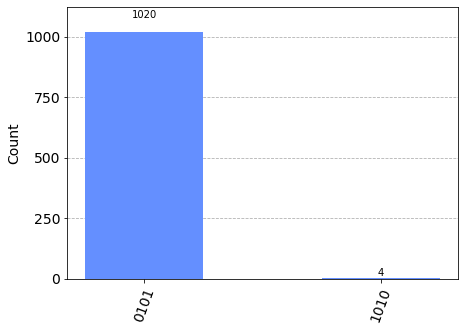

In [235]:
eigenstate_qc_list_noise = []
counts_list_noise = []
for i, distance in enumerate(distance_array):
    varform = initial_state_circuit()
    eigenstate_qc = varform.copy()
    eigenstate_qc.measure_all()
    opt_params = opt_param_qasm_noisy[i]

    param_dict = dict(zip(eigenstate_qc.parameters,opt_params))
    eigenstate_qc = eigenstate_qc.assign_parameters(param_dict)
    
    execute_opts = {'shots' : 1024}
    job = execute(eigenstate_qc,backend=qasm_simulator,**execute_opts)
    result = job.result()
    counts = result.get_counts(eigenstate_qc)
    
    eigenstate_qc_list_noise.append(eigenstate_qc)
    counts_list_noise.append(counts)
    
    
    
    
i = 3
display(eigenstate_qc_list_noise[i].draw('mpl'))
print(counts_list_noise[i])



from qiskit.visualization import plot_histogram
plot_histogram(counts_list_noise[i])

## Noiseless simulation

In [236]:
backend = qasm_simulator
execute_opts = {'shots' :2048, "noise_model": noise_model, 
                "basis_gates": fake_noisy_backend.configuration().basis_gates, 
                "coupling_map": fake_noisy_backend.configuration().coupling_map, 
                "seed_simulator": 1, "optimization_level" : 3, "resiliance_level" : 0}

d1 = np.arange(0.2,2.5,0.2)
d2 =np.array([0.735])
distance_array = np.concatenate((d1, d2))
distance_array = np.sort(distance_array)
# distance_array = np.arange(0.735, 0.935, 0.2)
opt_param_qasm_noiseless = []
GS_qasm_noiseless = []

for i, distance in enumerate(distance_array):
    distance = np.round(distance,decimals = 3)
    qubit_hamiltonian = read_integrals(distance)[0]
    energy_nuc = read_integrals(distance)[1]
    

    estimator = Estimator(read_integrals, initial_state_circuit, backend, execute_opts)
    vqe_solver = VQESolver(estimator,minimizer,[0,],name = 'vqe_solver')
    opt_value = vqe_solver.lowest_eig_value(qubit_hamiltonian)

    opt_param_qasm_noiseless.append(vqe_solver.last_opt_params)
    GS_qasm_noiseless.append(opt_value + energy_nuc)
    print('distance '+str(distance)+', energy : ', opt_value + energy_nuc)

distance 0.2, energy :  0.31751095163094156
distance 0.4, energy :  -0.7744289443283616
distance 0.6, energy :  -0.9817143581544011
distance 0.735, energy :  -1.0315439130875848
distance 0.8, energy :  -1.0261846603071159
distance 1.0, energy :  -0.989835738645006
distance 1.2, energy :  -0.9476281742842866
distance 1.4, energy :  -0.8839647762913685
distance 1.6, energy :  -0.8371578516338511
distance 1.8, energy :  -0.7887605219018191
distance 2.0, energy :  -0.7452500718692532
distance 2.2, energy :  -0.7077296049615267
distance 2.4, energy :  -0.687246469915212


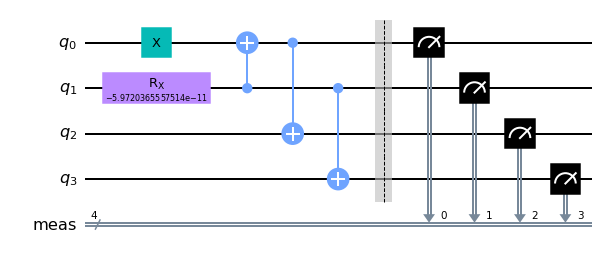

{'0101': 1024}


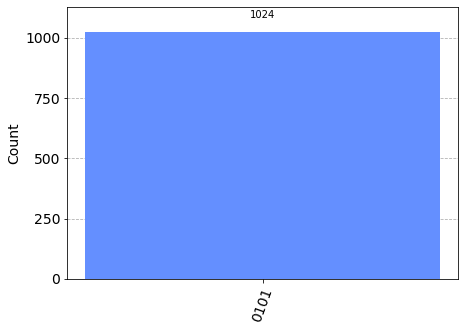

In [239]:
eigenstate_qc_list_noiseless = []
counts_list_noiseless = []
for i, distance in enumerate(distance_array):
    varform = initial_state_circuit()
    eigenstate_qc = varform.copy()
    eigenstate_qc.measure_all()
    opt_params = opt_param_qasm_noiseless[i]

    param_dict = dict(zip(eigenstate_qc.parameters,opt_params))
    eigenstate_qc = eigenstate_qc.assign_parameters(param_dict)
    
    execute_opts = {'shots' : 1024}
    job = execute(eigenstate_qc,backend=qasm_simulator,**execute_opts)
    result = job.result()
    counts = result.get_counts(eigenstate_qc)
    
    eigenstate_qc_list_noiseless.append(eigenstate_qc)
    counts_list_noiseless.append(counts)
    
    
    
    
i = 3
display(eigenstate_qc_list_noiseless[i].draw('mpl'))
print(counts_list_noiseless[i])



from qiskit.visualization import plot_histogram
plot_histogram(counts_list_noiseless[i])

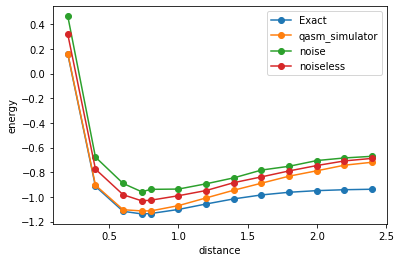

In [238]:
plt.plot(distance_array, ground_state_energy_exact, 'o-', label = 'Exact')
plt.plot(distance_array, Ground_state_energy, 'o-', label = 'qasm_simulator')
# plt.plot(distance_array, GS_ibm_simulator, 'o-', label = 'ibm_jakarta')
# plt.plot(distance_array, GS_ibm_simulator, 'o-', label = 'ibmq_qasm_simulator')
plt.plot(distance_array, GS_qasm_noisy, 'o-', label = 'noise')
plt.plot(distance_array, GS_qasm_noiseless, 'o-', label = 'noiseless')


plt.xlabel('distance')
plt.ylabel('energy')
plt.legend()
plt.show()